## Preprocessing using pipelines

This project involves predicting customer revenue based on various customer-related numeric features. The dataset contains high variance and complex data, making preprocessing essential for accurate predictions.

The dataset consists of the following features:

- f1, f2, ..., f15: Numeric customer-related features.
- f5: Target variable representing customer revenue.

The data has high variability, with standard deviations often exceeding the means, and contains several outliers. The preprocessing steps aim to clean, transform, and scale the data to make it suitable for machine learning models.

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

In [29]:
# Importing the dataset using pandas.
df = pd.read_csv('Data/data.csv')

In [30]:
# First things first
df.describe()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15
count,43279.00000,43279.000000,43279.000000,43279.000000,4.327900e+04,43279.000000,43279.000000,4.327900e+04,4.327900e+04,4.327900e+04,4.327900e+04,4.327900e+04,43279.000000,43279.000000,4.327900e+04
mean,1.33998,6.437348,0.521546,2437.707809,1.430649e+04,8.700987,11.582800,4.903085e+04,2.205454e+04,1.114433e+03,7.161331e+03,4.297935e+03,2.598535,0.683218,1.587574e+03
std,4.74484,23.992897,5.465637,9149.483506,2.067506e+05,28.571028,44.089354,6.343325e+06,1.960569e+05,3.935160e+04,5.328733e+04,3.700212e+04,4.410437,2.060159,1.322702e+04
min,0.00000,0.000000,0.000000,100.000000,-3.476300e+06,0.000000,0.000000,4.865000e-01,1.000000e+01,-3.476300e+06,0.000000e+00,0.000000e+00,0.000000,0.000000,9.090909e+00
25%,0.00000,0.000000,0.000000,150.000000,-1.862500e+01,0.000000,1.000000,2.620000e+00,5.000000e+02,-1.100000e+02,2.000000e+02,0.000000e+00,1.000000,0.000000,1.000000e+02
50%,1.00000,0.000000,0.000000,500.000000,4.992500e+02,2.000000,3.000000,5.015000e+00,1.926000e+03,2.000000e+02,1.000000e+03,0.000000e+00,1.000000,0.000000,3.493333e+02
75%,1.00000,1.000000,0.000000,2000.000000,2.500000e+03,6.000000,9.000000,1.245000e+01,7.341290e+03,1.000000e+03,3.000000e+03,1.000000e+03,2.000000,1.000000,1.000000e+03
max,327.00000,274.000000,248.000000,595000.000000,3.026204e+07,1589.000000,4652.000000,1.170174e+09,2.496558e+07,5.661600e+06,8.235000e+06,5.176300e+06,119.000000,105.000000,2.495000e+06


- Each of the 15 features (f1 to f15) has 43,279 non-null entries, indicating there are no missing values in the dataset;
- The mean values vary significantly across the features, suggesting a wide range of data types and scales. For instance, f1 has a mean of 1.34, while f8 has a much higher mean of 49,030.85;
- The standard deviation is quite large for some features, such as f8 (6,343,325) and f9 (196,056.9), indicating high variability. On the other hand, features like f1 (4.74) and f13 (4.41) have much lower standard deviations;
- The first quartile (Q1) values for many features are 0, indicating that at least 25% of the values are zeros for these features;
- The median values show the central tendency of the data. Features like f1, f2, f3, and f7 have medians of 1, 0, 0, and 3, respectively, suggesting a skewed distribution towards lower values for these features;
- The third quartile (Q3) values are higher than the medians, showing the spread of the upper half of the data. For example, f4 has a Q3 value of 2000, indicating that 25% of the data is above this value;
The maximum values indicate the extreme outliers in the dataset. For instance, f8 has a maximum value of 1.17 billion, which is exceptionally high compared to its mean and median. Similarly, f1 has a maximum value of 327, much higher than its mean.

## Potential Issues and Points of Interest:

- Outliers: The maximum values for many features are much higher than the mean and median, suggesting the presence of outliers. This might need further analysis to understand their impact.
- Zeros and Skewness: Several features have a significant proportion of zeros (e.g., f2, f3, f7), indicating a potential skewness in the data distribution.
- High Variability: Features with high standard deviations and large ranges (e.g., f8, f9) might require normalization or transformation for certain types of analysis.

## Preprocessing 

Identifying outliers

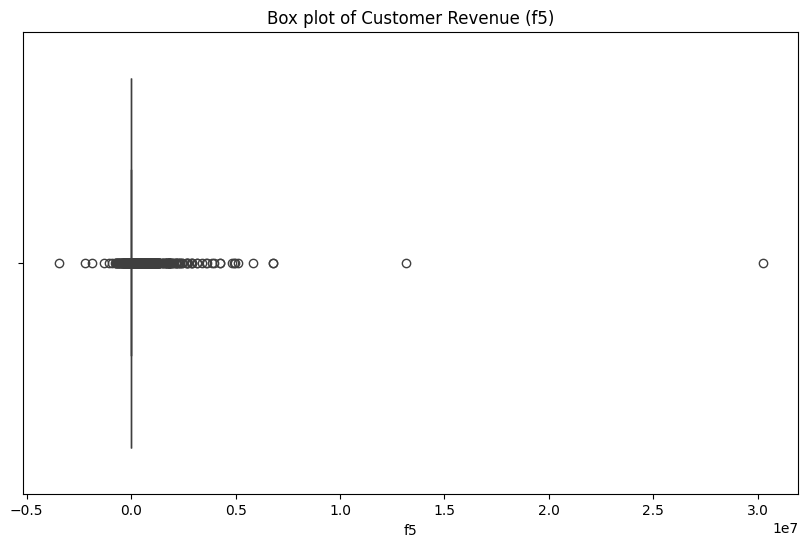

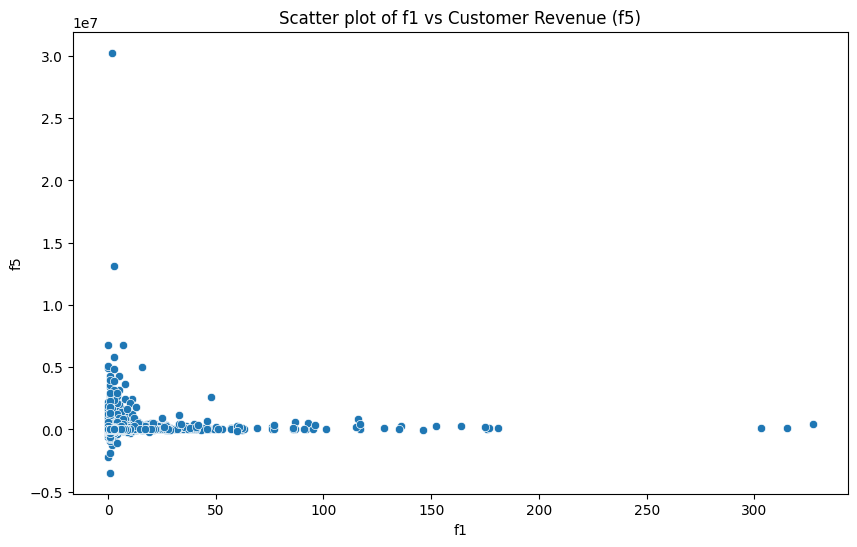

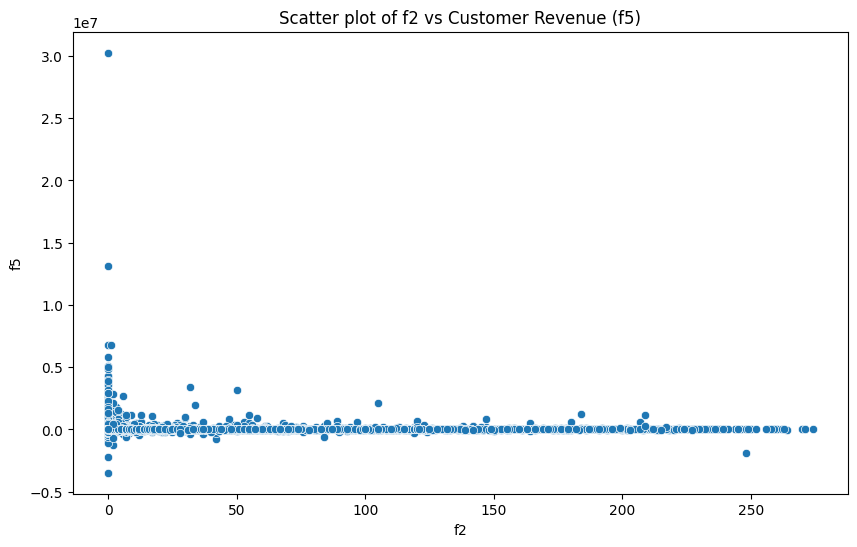

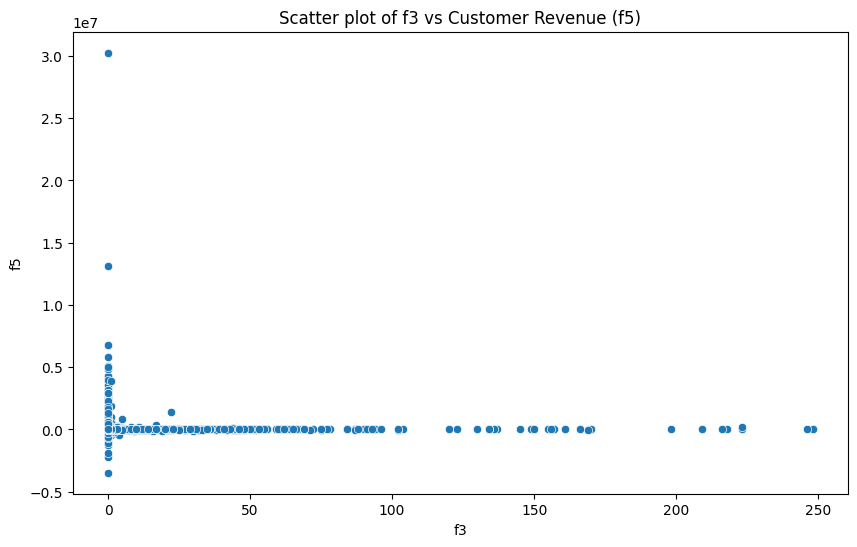

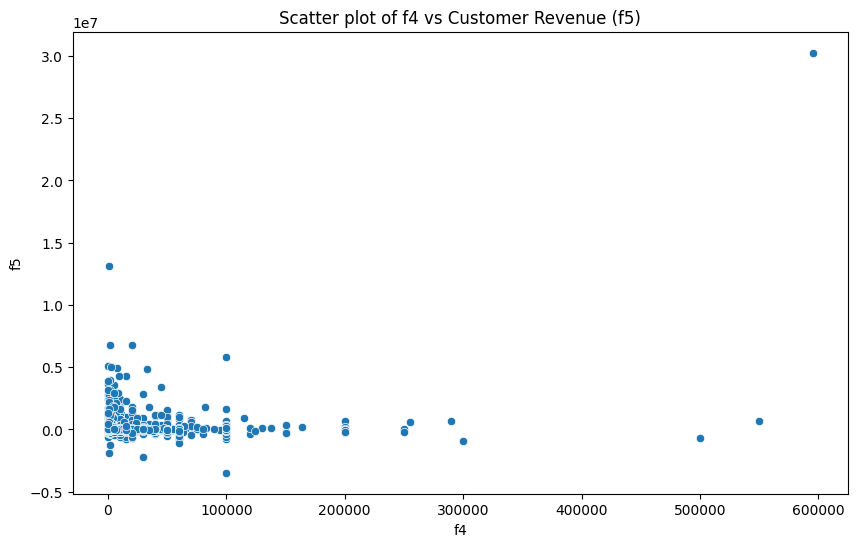

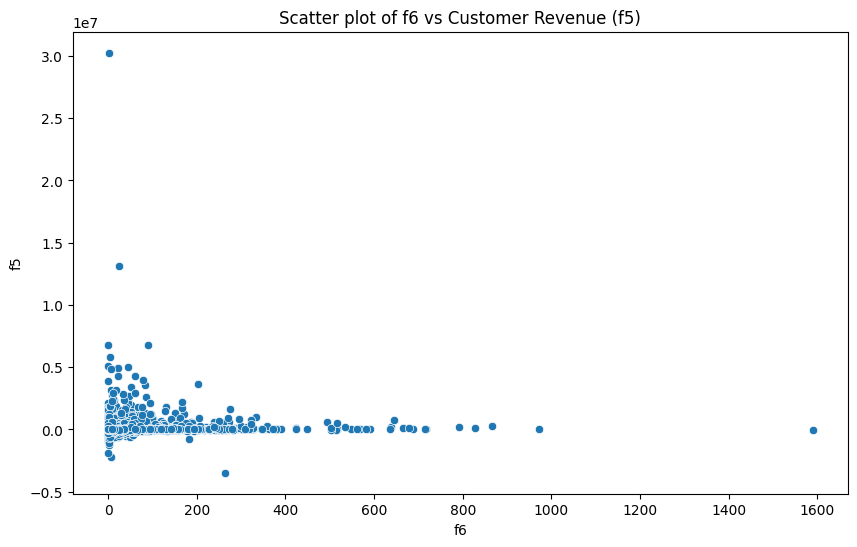

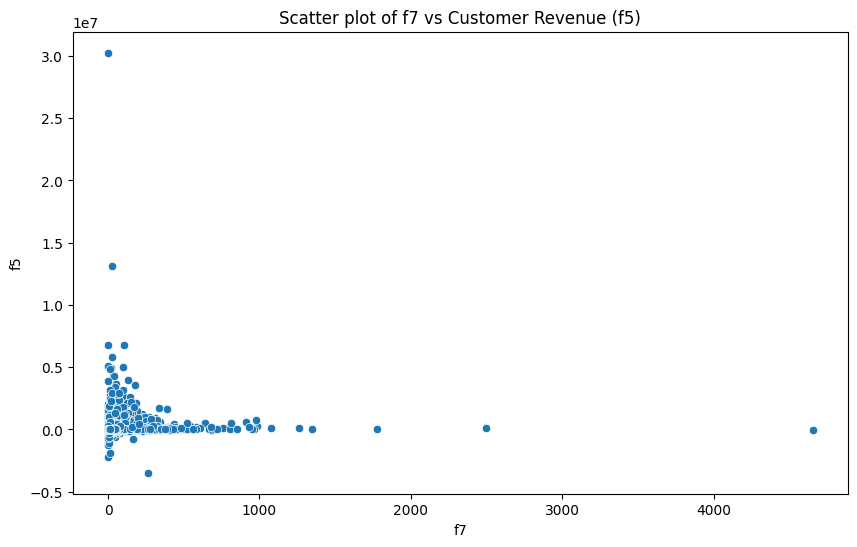

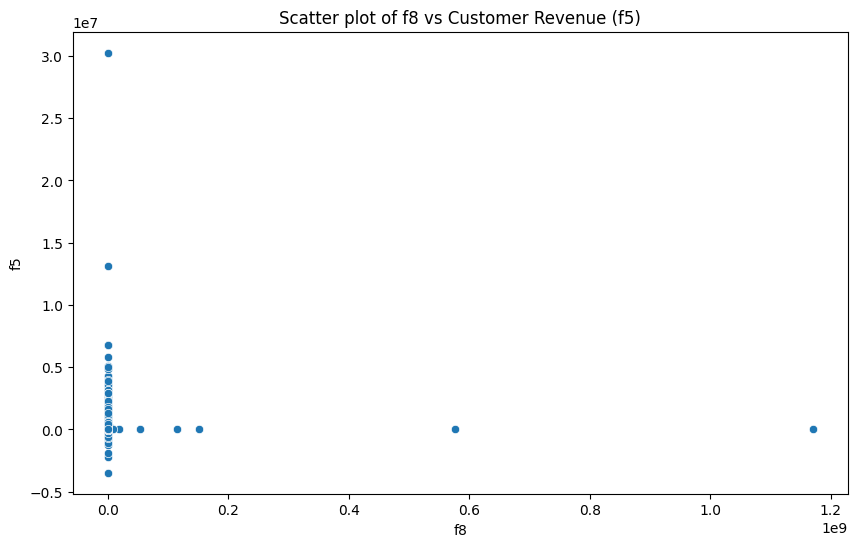

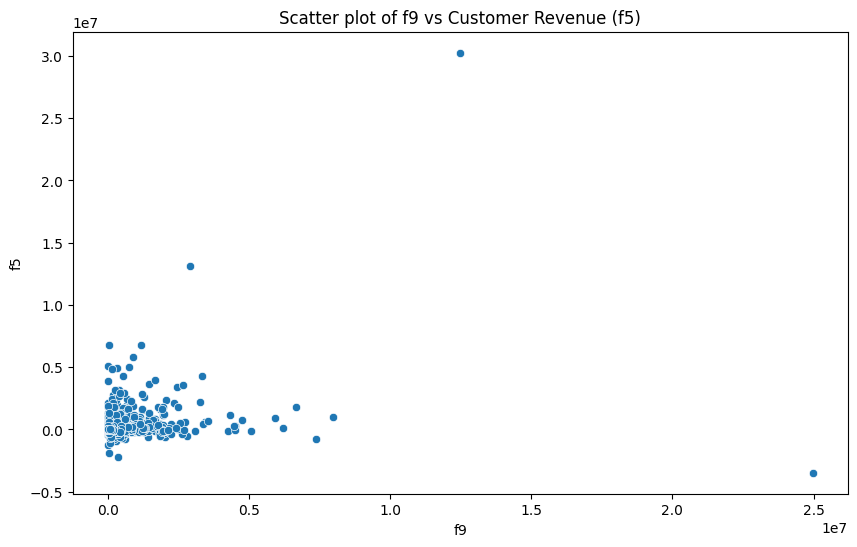

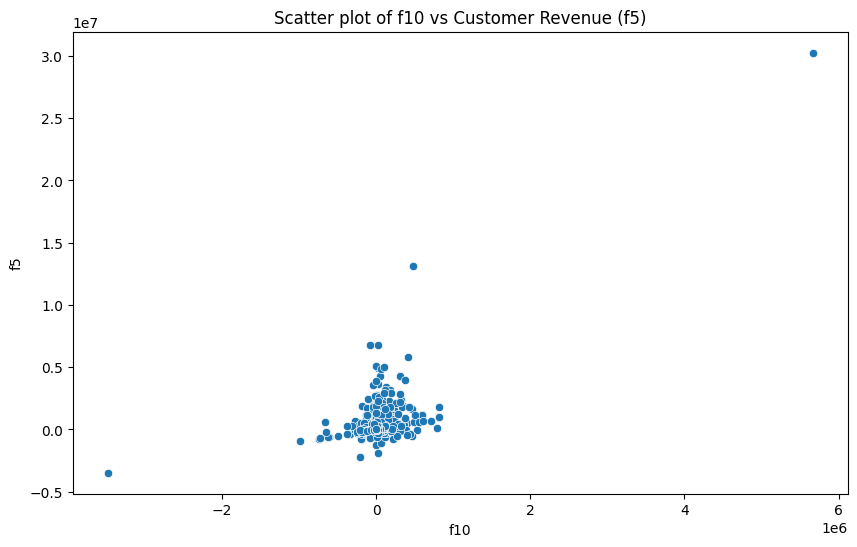

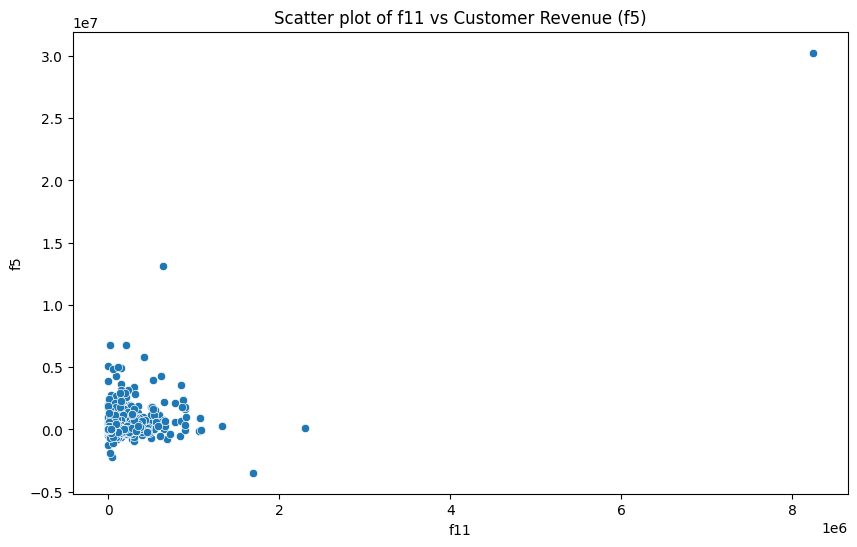

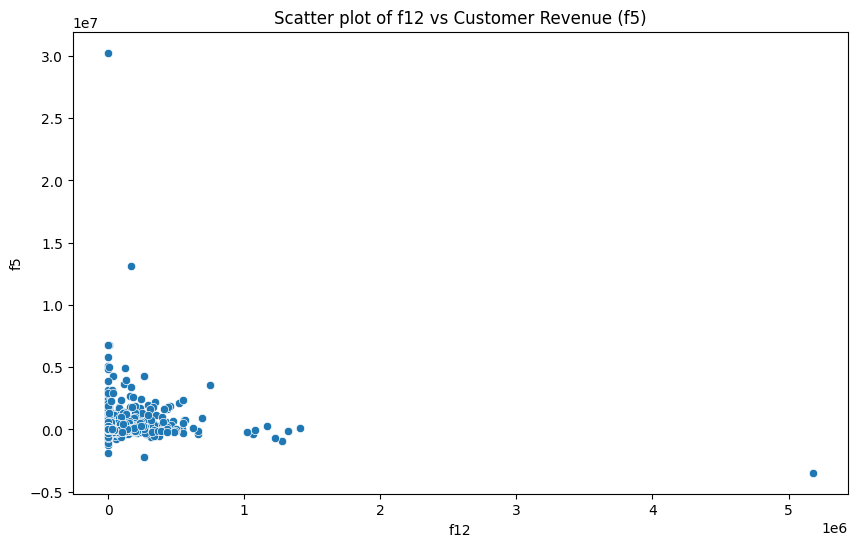

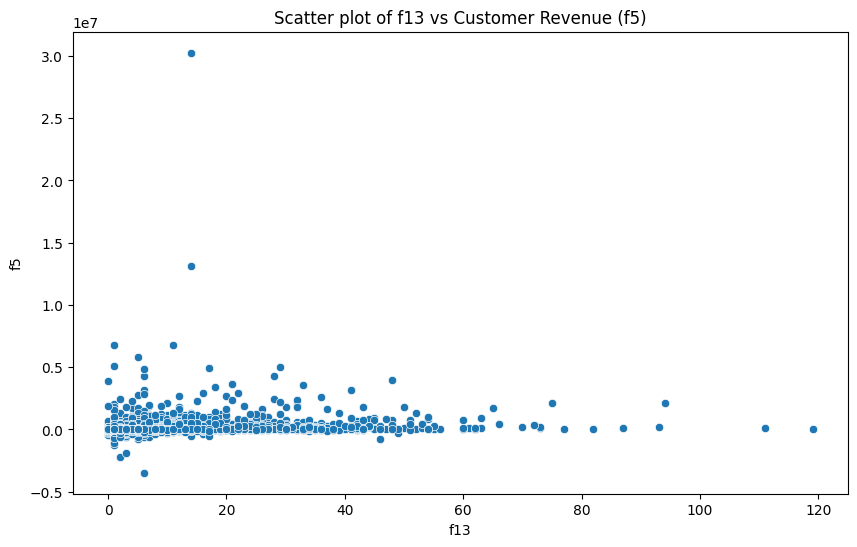

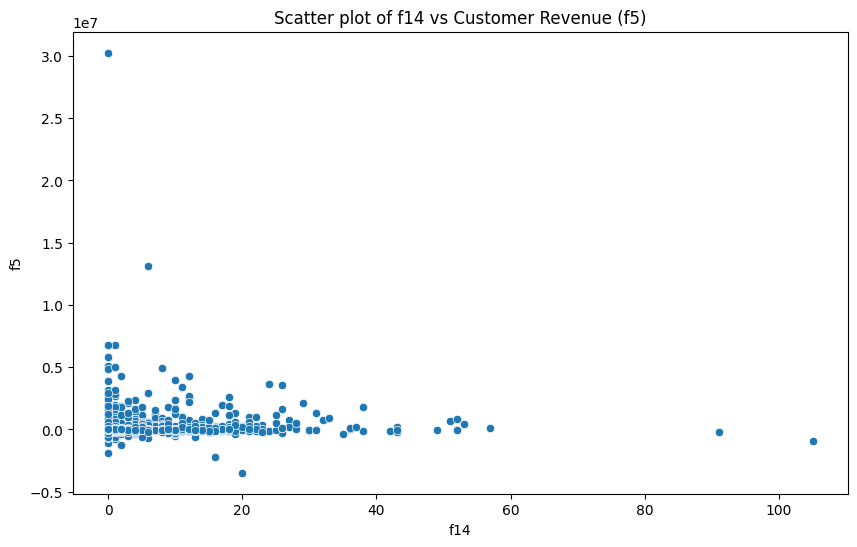

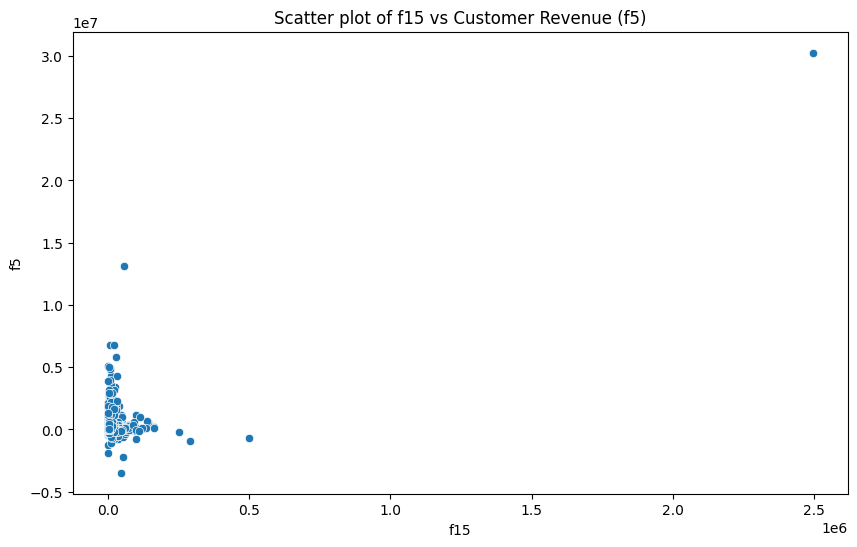

In [31]:
# Box plot for f5
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['f5'])
plt.title('Box plot of Customer Revenue (f5)')
plt.show()

# Scatter plot for other features vs f5
for feature in df.columns:
    if feature != 'f5':
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=df[feature], y=df['f5'])
        plt.title(f'Scatter plot of {feature} vs Customer Revenue (f5)')
        plt.show()

In [32]:
def find_outliers_iqr(df):
    outliers = {}
    for column in df.columns:
        if df[column].dtype in ['int64', 'float64']:
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers[column] = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return outliers

outliers = find_outliers_iqr(df)
outliers_f5 = outliers['f5']
print(outliers_f5)


0          50599.01
3          17810.34
4         -55270.00
5        1132457.24
8         353883.12
            ...    
43265       8386.00
43270      26030.25
43272     -15434.02
43274   -1883165.50
43277     440109.12
Name: f5, Length: 11186, dtype: float64


In [36]:
# I prefer to use Capping/Flooring in this case, since all the records are accurate, according to business, I just need to limit their influence

def cap_floor_outliers(df, feature, lower_quantile=0.01, upper_quantile=0.99):
    lower_bound = df[feature].quantile(lower_quantile)
    upper_bound = df[feature].quantile(upper_quantile)
    df[feature] = np.where(df[feature] < lower_bound, lower_bound, df[feature])
    df[feature] = np.where(df[feature] > upper_bound, upper_bound, df[feature])
    return df

data = cap_floor_outliers(df, 'f5', 0.01, 0.99)


## Feature Scaling using pipelines

After fixing the outlier problem, I need to consider feature scaling, as machine learning algorithms benefit from scaled data. Applying a transformation can also help reduce skewness. In order to select the best method, I used pipelines. For each pipeline, I train a GradientBoostingRegressor and evaluate the performance using the R² score. I choose GradientBoostingRegressor because there is no obvious linear dependence on the target variable according to the plots.

By evaluating multiple preprocessing pipelines, I identified the best approach for predicting customer revenue. Here is how I've done it:

In [40]:
# Identifying numeric features
numeric_features = data.columns.tolist()

# Remove the target variable from numeric features
numeric_features.remove('f5')

# Define transformations
log_transformer = FunctionTransformer(np.log1p, validate=True)
yeo_johnson_transformer = PowerTransformer(method='yeo-johnson', standardize=False)

# Define scalers
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()

# Combinations of transformations and scalers
transformers = [log_transformer, yeo_johnson_transformer]
scalers = [standard_scaler, robust_scaler]
transformer_names = ['log', 'yeo_johnson']
scaler_names = ['standard', 'robust']

# Prepare the target variable and features
X = data.drop('f5', axis=1)
y = data['f5']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Store results
results = []

# Custom function to handle non-positive values before log transformation
def safe_log1p(x):
    return np.log1p(np.clip(x, a_min=1e-9, a_max=None))

# Custom log transformer to handle non-positive values
safe_log_transformer = FunctionTransformer(safe_log1p, validate=True)

# Iterate over each combination of transformer and scaler
for transformer, t_name in zip([safe_log_transformer, yeo_johnson_transformer], transformer_names):
    for scaler, s_name in zip(scalers, scaler_names):
        
        # Create the preprocessing pipeline
        preprocessor = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Handle NaNs before any transformation
            (t_name, transformer),
            (s_name, scaler),
            ('imputer2', SimpleImputer(strategy='mean'))  # Handle NaNs that may appear after transformation
        ])

        # Combine preprocessing and model into a single pipeline
        model_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', GradientBoostingRegressor(random_state=42))
        ])

        # Fit the model
        model_pipeline.fit(X_train, y_train)

        # Predict and evaluate
        y_pred = model_pipeline.predict(X_test)
        score = r2_score(y_test, y_pred)
        results.append((f'{t_name}_{s_name}', score))

        print(f'Pipeline: {t_name}_{s_name}, R2 Score: {score:.4f}')

# Find the best pipeline
best_pipeline = max(results, key=lambda x: x[1])
print(f'\nBest Pipeline: {best_pipeline[0]}, R2 Score: {best_pipeline[1]:.4f}')


Pipeline: log_standard, R2 Score: 0.3820
Pipeline: log_robust, R2 Score: 0.3821
Pipeline: yeo_johnson_standard, R2 Score: 0.3762
Pipeline: yeo_johnson_robust, R2 Score: 0.3766

Best Pipeline: log_robust, R2 Score: 0.3821


This workflow outlines the steps taken to preprocess the data, handle outliers, apply transformations and scaling, and train a Gradient Boosting Regressor. By evaluating multiple preprocessing pipelines, I identified the best approach for predicting customer revenue.